<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file rerepresents an event. All events are related to products and users. Each event is like many-many relation between users and products. 

## Learning Objectives

At the end of this session, you will be able to
- Detect data imbalance
- Practice more on preprocessing features
- Build logistic regression / SVM / Gradient Boosting / Random Forest models
- Evaluate models with proper metrics
- Interpret black box models

## Task 1: Load data

We start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

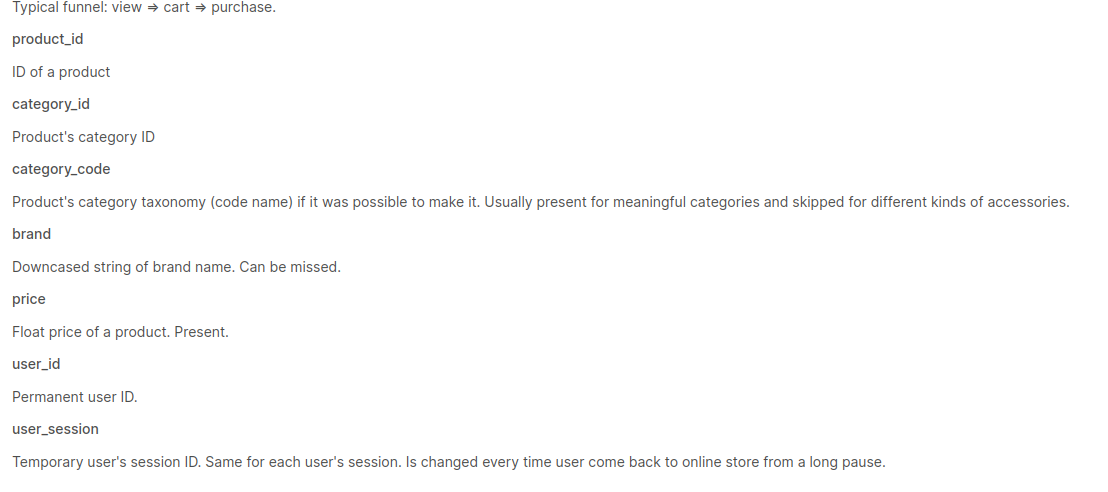

In [1]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

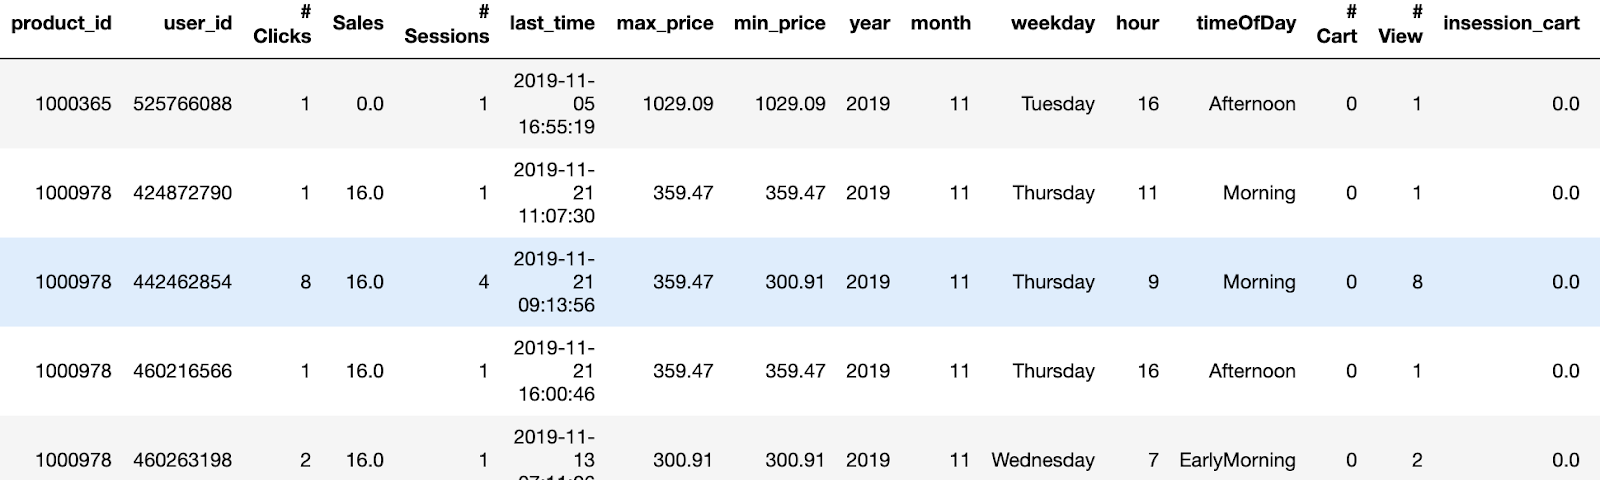

In [2]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has either 0 (not purchased) or 1 (purchased).

In [3]:
import pandas as pd
train_df = pd.read_csv("../dat/train.csv.gz")

In [4]:
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


4. What is the dimension of the training data?

In [5]:
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [6]:
test_df = pd.read_csv("../dat/test.csv.gz")
test_df.shape # (430544, 15)

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. As part of this, we will want to identify what features are most important for making this classification.

We'll start with digging into our dataset.

1. For the training data, print out the datatype of each feature (column), and identify which ones are non-numeric.

In [7]:
train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

<details> 
<summary>Expected output:</summary>

    NumOfEventsInJourney      int64
    NumSessions               int64
    interactionTime         float64
    maxPrice                float64
    minPrice                float64
    NumCart                   int64
    NumView                   int64
    InsessionCart             int64
    InsessionView             int64
    year                      int64
    month                     int64
    weekday                  object
    timeOfDay                object
    Weekend                   int64
    Purchase                  int64
    dtype: object
</details>

2. Print the unique values for the year, month and weekend features.

In [8]:
print('   year:',train_df.year.unique())
print('  month:', train_df.month.unique())
print('weekend:',train_df.Weekend.unique())

   year: [2019]
  month: [11]
weekend: [0]


What does weekend: 0 mean? The column "weeken" could referd to a flag column that use 1 and 0 as indication that the purchase was done in a weekend

3. Since these columns each only have one unique value, they will not be valuable features, we drop the three columns in the training set. Pass the `columns` argument to the `.drop()` method. Make sure to use `inplace=True` to modify the DataFrame. Print the shape of the DataFrames to verify the columns were dropped.

In [9]:
print(train_df.shape) 
train_df = train_df.drop(["year","month","Weekend"],axis=1)
print(train_df.shape)

(645816, 15)
(645816, 12)


<details> 
<summary>Expected output:</summary>

   (645816, 15)
   
   (645816, 12)
</details>

4. Repeat the step for `test_df`:

In [10]:
print(test_df.shape)
test_df = test_df.drop(["year","month","Weekend"],axis=1)
print(test_df.shape)

(430544, 15)
(430544, 12)


<details> 
<summary>Expected output:</summary>

(430544, 15)

(430544, 12)
</details>

4. For each non-numeric feature, print the unique values.

In [11]:
print('  weekday:', train_df.weekday.unique())
print('timeOfDay:', train_df.timeOfDay.unique())

  weekday: ['Sat' 'Fr' 'Thu' 'Mon' 'Tue' 'Wed' 'Sun']
timeOfDay: ['Morning' 'Dawn' 'Afternoon' 'Noon' 'Evening' 'EarlyMorning' 'Night']


<details>
<summary> Expected output:</summary>
  
  weekday: ['Wed' 'Fr' 'Sat' 'Sun' 'Tue' 'Thu' 'Mon']

timeOfDay: ['EarlyMorning' 'Morning' 'Afternoon' 'Dawn' 'Evening' 'Night' 'Noon']
</details>

5. Convert the non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to do so. Follow the example given for the `weekday` column to update the `timeOfDay` column. Use the `.head()` method to inspect the dataset after the transformations.

In [12]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,6,Morning,0
1,1,1,0.0,92.67,92.67,0,1,0,1,5,Dawn,0
2,1,1,0.0,155.71,155.71,0,1,0,1,4,Afternoon,0
3,1,1,0.0,898.32,898.32,0,1,0,1,1,Noon,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2,Noon,0


In [13]:
train_df.timeOfDay.unique()

array(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'], dtype=object)

In [14]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate(['Dawn','EarlyMorning','Morning','Noon','Afternoon','Evening','Night'])
}
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num)
train_df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,6,3,0
1,1,1,0.0,92.67,92.67,0,1,0,1,5,1,0
2,1,1,0.0,155.71,155.71,0,1,0,1,4,5,0
3,1,1,0.0,898.32,898.32,0,1,0,1,1,4,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2,4,0


In [15]:
train_df.timeOfDay.unique() 

array([3, 1, 5, 4, 6, 2, 7])

<details>

<summary> Expected output:</summary>

array([3, 1, 5, 4, 6, 2, 7])
</details>

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric. 

In [18]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num)

In [19]:
test_df

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,weekday,timeOfDay,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,3,2,0
1,2,2,182.0,118.38,118.38,0,2,0,1,5,2,0
2,1,1,0.0,63.77,63.77,0,1,0,1,5,3,0
3,1,1,0.0,32.18,32.18,0,1,0,3,5,2,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
430539,1,1,0.0,25.48,25.48,0,1,0,1,3,6,0
430540,1,1,0.0,16.47,16.47,0,1,0,1,6,3,0
430541,1,1,0.0,38.61,38.61,0,1,0,2,4,6,0
430542,3,2,142943.0,486.47,427.16,0,3,0,2,7,1,0


7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Are the datasets balanced?

In [20]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
print(f"percent of rows resulting in purchase: {100*round(train_df.Purchase.mean(),4)}%") # YOUR CODE HERE

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase: 1.39%


<details>

<summary> Expected output:</summary>

    number of purchases vs non-purchases in train set:
    0    636839
    1      8977
    Name: Purchase, dtype: int64
    percent of rows resulting in purchase: 1.39%
<details>

## Task 3: Remove highly correlated features

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forests can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [21]:
print("Number of features {}".format(train_df.shape[-1]-1)) #Number of columns Minus target variable

Number of features 11


<details>
<summary>Expected output:</summary>
    
    The training data currently has 11 features
</details>

2. Draw a heatmap of the Pearson correlation.

    The plotting code is given to you, but you need to fill in the calculation of the Pearson correlation (`pd.DataFrame.corr()`). Note that we here use a smaller sample of the total training dataset for calculating correlation and rendering heatmap. 

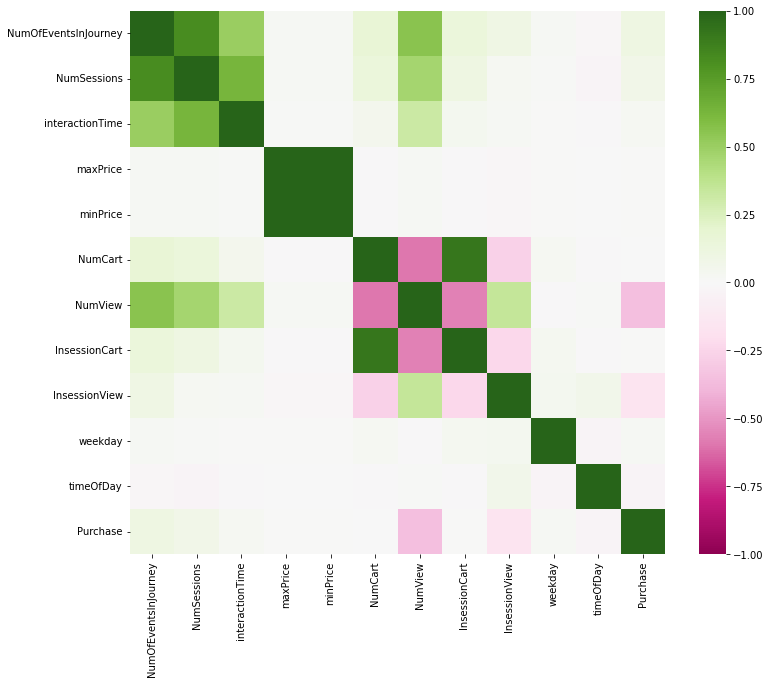

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 
plt.figure(figsize=(12, 10))
cor = train_small_df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, cmap="PiYG");

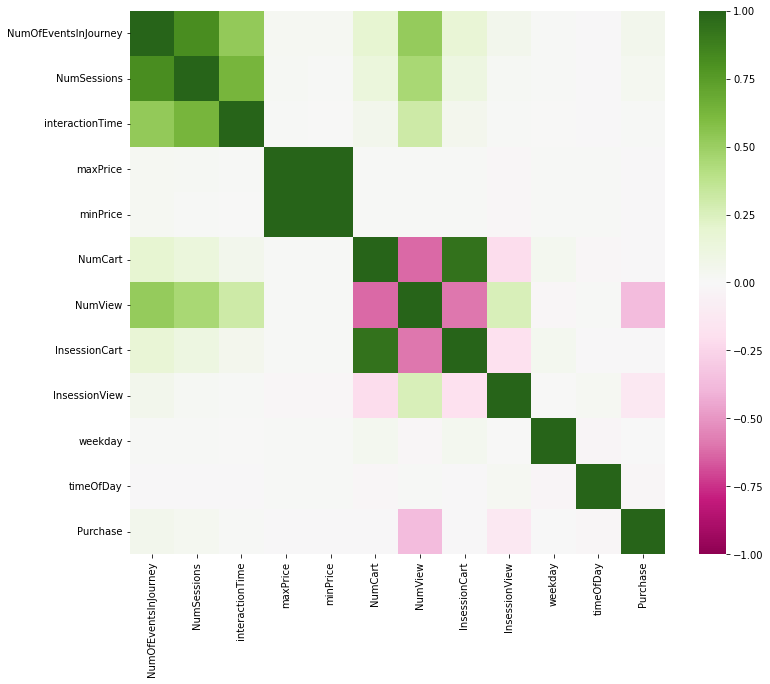

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

train_small_df = train_df.copy().sample(n=int(1e4), random_state=7654) 
plt.figure(figsize=(12, 10))
cor = train_small_df.corr()
sns.heatmap(cor, vmin=-1, vmax=1, cmap="PiYG");

In [24]:
# Expected output:

3. Drop the features with high correlation.

    We'll do this by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given the code, make sure that you understand what each line does.

In [25]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [26]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


4. How many columns are left in the DataFrame?

In [27]:
# YOUR CODE HERE # Expected: The training data now has 8 features
print("Number of features {}".format(train_df_reduced.shape[-1]-1)) #Number of columns Minus target variable

Number of features 8


In [28]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

5. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [29]:
test_df_reduced = test_df[train_df_reduced.columns]
test_df_reduced.shape # Expected: (430544, 9)

(430544, 9)

6. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

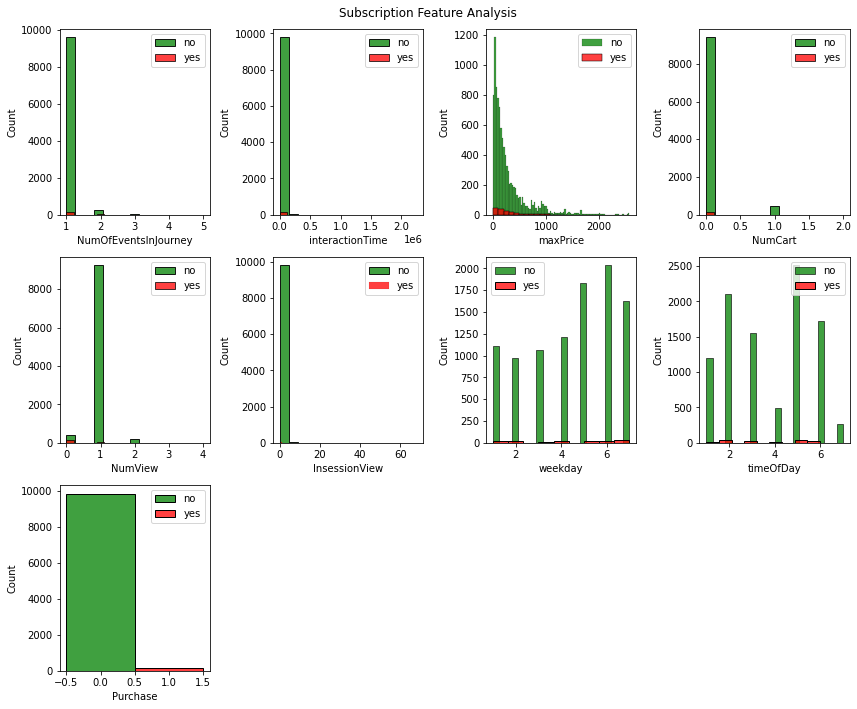

In [30]:
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

7. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [31]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values

8. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

## Task 4: Build logistic regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict with the Logistic Regression model.

    Make sure to account for the imbalanced classes with with `class_weight` parameter.

    Remember to use the ***train*** data for building the model and the ***test*** data when making and evaluating the predictions

In [38]:
%%time
lr_model = LogisticRegression(class_weight={0: 0.06467336683417085, 1: 0.9353266331658292})
lr_model.fit(X=X_train_reduced,y=y_train)
lr_pred = lr_model.predict(X=X_test_reduced) 

CPU times: user 27.3 s, sys: 20.9 s, total: 48.2 s
Wall time: 4.53 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [40]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9992613995317552
precision: 0.9890424814565071
recall: 0.9586601307189543
f1 score: 0.9736143378692332
confusion matrix:
[[424359     65]
 [   253   5867]]


4. Instantiate, train and predict with the SVM mode. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account fo the imbalanced classes.

In [42]:
%%time
svm_model = LinearSVC(class_weight={0: 0.06467336683417085, 1: 0.9353266331658292})
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 6.62 s, sys: 38 ms, total: 6.66 s
Wall time: 6.61 s


Support Vector Machine is  supervised learning algorithm in which the main goal is to found a Line and supports (a street between the data points) that separate the target class. This mean that it found a line that separate but also optimize the distance that can be use to classify between targets. Depending of the type of problem it is very powerful because use different comnbination of techniques to make it more flexible (Kernel trick, Hard and Soft boundaries).

Disanvantages: training time depending on the kernel and optimizer used. Also it doesnt gives a probability given that is only use support to classify. Not suitable for big data 

5. What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770).

* SVM - LineasSVC O(nm^2)
* Logistic regresion O(nm)

6. Calculate the classification metrics for the SVM model. Here you can use a helper function to display all the metrics, inspect the source code to understand how to use the function.

In [43]:
from utils import display_metrics
display_metrics(y_test, svm_pred)

Confusion Matrix: 
[[424424      0]
 [     0   6120]]
Accuracy: 1.000
Recall: 1.000
Precision: 1.000
F1 Score: 1.000


<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424424      0]
    [     0   6120]]
    Accuracy: 1.000
    Recall: 1.000
    Precision: 1.000
    F1 Score: 1.000

</details>

Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Fit a non-linear classifier: gradient boosted tree

1. Instantiate, train, and predict with the Gradient Boosted Trees model.

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [47]:
%%time
gbt_model = GradientBoostingClassifier()
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 44.1 s, sys: 0 ns, total: 44.1 s
Wall time: 44.1 s


2. Evaluate the model by calculating the classification metrics.

In [48]:
display_metrics(y_test, gbt_pred)

Confusion Matrix: 
[[424423      1]
 [    16   6104]]
Accuracy: 1.000
Recall: 0.997
Precision: 1.000
F1 Score: 0.999


<details>
<summary> Expected output:</summary>

    Confusion Matrix: 
    [[424423      1]
    [    16   6104]]
    Accuracy: 1.000
    Recall: 0.997
    Precision: 1.000
    F1 Score: 0.999

</details>

## Task 6: Analyze importace of data sample balancing with random forest model

1. Instantiate, train, predict with, and evaluate an unbalanced random forest classifier. (Follow the same steps you did above with the other models). You can use 100 trees in the forest, and set the maximum depth of the tree at 5. 

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5)
rf_model.fit(X_train_reduced, y_train)
rf_pred = rf_model.predict(X_test_reduced)

CPU times: user 23 s, sys: 15.3 ms, total: 23 s
Wall time: 23 s


In [51]:
display_metrics(y_test, rf_pred)

Confusion Matrix: 
[[424424      0]
 [   690   5430]]
Accuracy: 0.998
Recall: 0.887
Precision: 1.000
F1 Score: 0.940


2. Repeat the previous exercise, but this time, incorporate **class-balanced penalty weights**

In [52]:
%%time
rf_model_b = RandomForestClassifier(n_estimators=100, max_depth=5,class_weight={0: 0.06467336683417085, 1: 0.9353266331658292})
rf_model_b.fit(X_train_reduced, y_train)
rf_pred_b = rf_model_b.predict(X_test_reduced)

CPU times: user 23.3 s, sys: 28.2 ms, total: 23.4 s
Wall time: 23.4 s


In [53]:
display_metrics(y_test, rf_pred_b)

Confusion Matrix: 
[[423862    562]
 [    92   6028]]
Accuracy: 0.998
Recall: 0.985
Precision: 0.915
F1 Score: 0.949


3. Visualize a Decision Tree. Spend some time inspecting this visualization of the tree--what does each line in the boxes mean? Discuss this with your partners. What does the "value=..." line indicate?

In [54]:
from sklearn.tree import export_graphviz
from subprocess import call

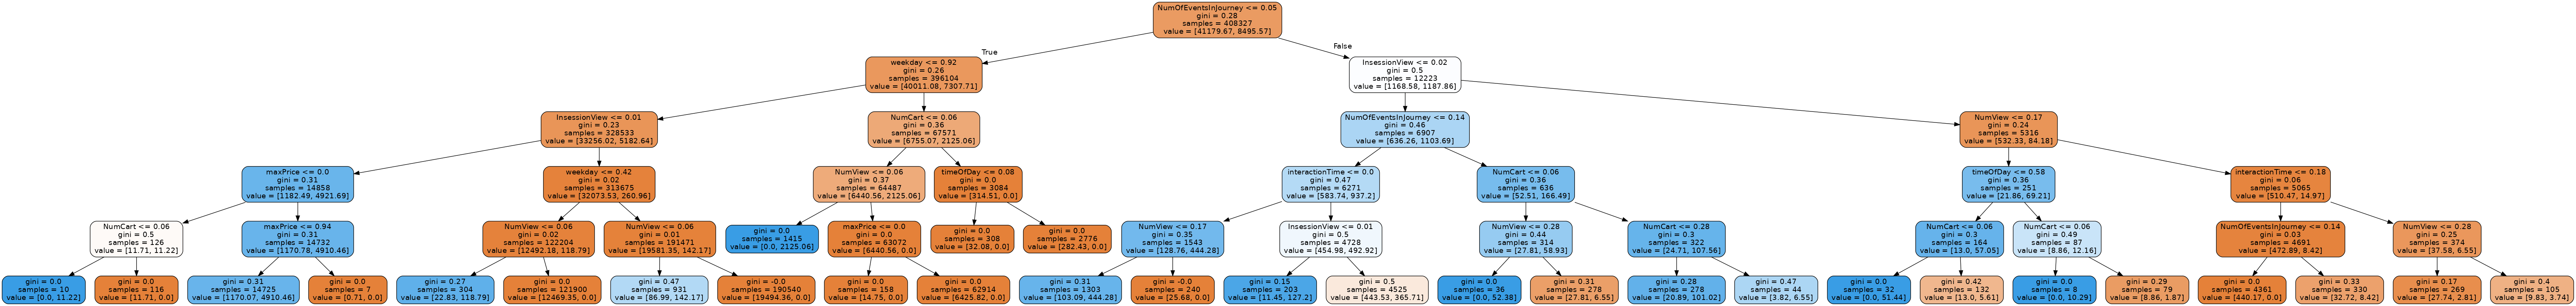

In [68]:
export_graphviz(rf_model_b.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = selected_columns[:-1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=100'])
Image(filename = 'tree.png')

4. Look at the results below to note the most important features.

In the cell below we show you how to use a Random Forest to rank features based on a measure of importance called the Gini Importance. We'll provide you with all the code, but you may want to read up on sklearn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and its [feature_importances_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) property.

Feature ranking:


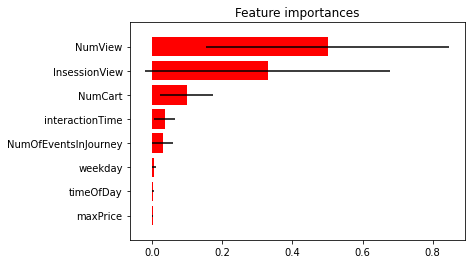

In [66]:
# Use Random Forest to get feature ranks/importances for each feature
importances = rf_model_b.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_b.estimators_],
             axis=0)
indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

names = []
for f in range(X_train_reduced.shape[1]):
    #print("%d. %s (feature %d) (%f)" %(f + 1, train_df_reduced.columns[indices[f]], indices[f], importances[indices[f]]))
    names.append(train_df_reduced.columns[indices[f]])

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train_reduced.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
plt.yticks(range(X_train_reduced.shape[1]), names)
plt.ylim([-1, X_train_reduced.shape[1]]);

The Feature importance graph shows how much contribution on average a variable have within the trees (Random Forest) and the variability in the contribution. For example InsessionVies looks that have on average a good contribution but across all the trees of the RandomForest it is not consistency (given the high variation)

Thus features 4 and 5 (numview, InsessionView) are the top two most important features (according to the Random Forest model). Is this what you expected? Bonus question, is it necessary to scale features for when fitting random forest models? No, Because it takes into consideration the variable to compute the impurity

## Optional Task: Explanability with SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

For this optional task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. Can you apply `shap.Explainer()` to calculate the SHAP values for the XGBoost and Random Forest models you fit earlier, visualize the effects over all samples using `shap.plots.beeswarm()` and interpret the results? Consider experimenting it on a smaller dataset first. 

Want to get more details? Please go ahead and check these links:

1. [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
2. [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

**SHAP** Use the features as player and start the process of iterate over diferent attributes of the players and start looking and the main impact by a pertubation of a player 

## References

- This work is motivated by the [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)